# 19 : Transformations non linéaires

## Transformations variables

In [1]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

def load_california_housing_data():
    dataset = fetch_california_housing()
    X = pd.DataFrame(data=dataset.data, 
                     columns=dataset.feature_names)
    y = pd.Series(data=dataset.target, name="target")
    print(dataset.DESCR)
    return X, y

X, y = load_california_housing_data()

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [2]:
X["AveOccup"] = X["AveOccup"].clip(upper=100)

X['AveOccupRooms'] = X['AveOccup'] / X['AveRooms']
X['AveOccupBedrms'] = X['AveOccup'] / X['AveBedrms']
X['Rooms_capita'] = X['Population'] / X['AveRooms']
X['Bedrms_capita'] =  X['Population'] / X['AveBedrms']
X['Bedrms_pct'] = X['AveBedrms'] / X['AveRooms']

In [3]:
import numpy as np
from sklearn.feature_selection import f_regression

single_variable = X["AveOccup"].values.reshape(-1, 1)
F, pval = f_regression(single_variable, y)
print(f'F score de la caractéristique originelle {F[0]:.1f}')

F, pval = f_regression(np.log1p(single_variable),y)
print(f'F score de la caractéristique transformée {F[0]:.1f}')

F score de la caractéristique originelle 275.8
F score de la caractéristique transformée 1434.7


## Interactions entre variables

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection  import cross_val_score, KFold

regression = Pipeline([("scaler", StandardScaler()), ("model",LinearRegression())])
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)

baseline = np.mean(cross_val_score(regression, X, y, 
                                   scoring='neg_mean_squared_error', 
                                   cv=crossvalidation))

print(f'Erreur quadra de la référence Baseline: {abs(baseline):.3f}')

Erreur quadra de la référence Baseline: 0.507


In [5]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures((2, 2), interaction_only=True, include_bias=False)
features = ["MedInc", "HouseAge", "Population", "AveRooms", "AveBedrms", "AveOccup"]
poly.fit(X[features])
interactions = pd.DataFrame(poly.transform(X[features]), columns=poly.get_feature_names_out(features))


In [6]:
print(interactions.shape)

(20640, 15)


In [7]:
for col in interactions:
    Xt = pd.concat([X, interactions[col]], axis=1)
    
    test = np.mean(cross_val_score(regression, Xt, y, 
                                   scoring='neg_mean_squared_error', 
                                   cv=crossvalidation))
    if test > baseline:
        print(f"Avec interaction {col} erreur MSE passe à {abs(test):0.3f}")

Avec interaction MedInc HouseAge erreur MSE passe à 0.504
Avec interaction MedInc Population erreur MSE passe à 0.500
Avec interaction MedInc AveRooms erreur MSE passe à 0.501
Avec interaction MedInc AveBedrms erreur MSE passe à 0.506
Avec interaction MedInc AveOccup erreur MSE passe à 0.507
Avec interaction HouseAge Population erreur MSE passe à 0.506
Avec interaction Population AveOccup erreur MSE passe à 0.490


# Régularisation de modèles linéaires

## Régression ridge

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

Xt = pd.concat([X, interactions], axis=1)

ridge = Pipeline([("scaler", StandardScaler()), ("model",Ridge())])
search_grid = {'model__alpha': np.logspace(-6, 4, 20)}
search = GridSearchCV(estimator=ridge, 
                      param_grid=search_grid, 
                      scoring='neg_mean_squared_error', 
                      refit=True, cv=crossvalidation)
search.fit(Xt, y)
print(f'Meilleurs paramètres: {search.best_params_}')
score = abs(search.best_score_)
print(f'Erreur MSE CV des meilleurs paramètres: {score:.3f}')

Meilleurs paramètres: {'model__alpha': 263.6650898730355}
Erreur MSE CV des meilleurs paramètres: 0.499


## Technique Lasso

In [9]:
from sklearn.linear_model import Lasso
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
 
lasso = Pipeline([("scaler", StandardScaler()), ("model",Lasso(selection='random'))])

search_grid = {'model__alpha': np.logspace(-6, 4, 20)}
search = GridSearchCV(estimator=lasso, 
                      param_grid=search_grid, 
                      scoring='neg_mean_squared_error', 
                      refit=True, cv=crossvalidation)
search.fit(Xt, y)
best_alpha = search.best_params_
print(f'Meilleurs paramètres: {search.best_params_}')
score = abs(search.best_score_)
print(f'Erreur MSE CV des meilleurs paramètres: {score:.3f}')

Meilleurs paramètres: {'model__alpha': 0.004832930238571752}
Erreur MSE CV des meilleurs paramètres: 0.493


## Régularisation et sélection de caractéristiques

In [10]:
selection = np.abs(
    search.best_estimator_["model"].coef_) > 0
print(Xt.columns[selection].tolist())

['MedInc', 'HouseAge', 'AveRooms', 'AveOccup', 'Latitude', 'Longitude', 'AveOccupRooms', 'AveOccupBedrms', 'Rooms_capita', 'Bedrms_capita', 'Bedrms_pct', 'MedInc HouseAge', 'MedInc Population', 'MedInc AveRooms', 'HouseAge Population', 'HouseAge AveOccup', 'Population AveRooms', 'Population AveOccup']


## Combinaison de L1 & L2 : Elasticnet

In [11]:
from sklearn.linear_model import ElasticNet

elastic = Pipeline([("scaler", StandardScaler()), ("model", ElasticNet(selection='random'))])
search_grid = {'model__alpha': np.logspace(-6, 4, 20), 
               'model__l1_ratio': [0.05, 0.10 ,0.25, 0.5, 0.75, 0.90, 0.95]}
search = GridSearchCV(estimator=elastic, 
                      param_grid=search_grid, 
                      scoring='neg_mean_squared_error', 
                      refit=True, cv=crossvalidation)
search.fit(Xt, y)
print(f'Meilleurs paramètres: {search.best_params_}')
score = abs(search.best_score_)
print(f'Erreur MSE CV des meilleurs paramètres: {score:.3f}')


Meilleurs paramètres: {'model__alpha': 0.004832930238571752, 'model__l1_ratio': 0.95}
Erreur MSE CV des meilleurs paramètres: 0.493


# Gestion progressive de gros volumes de données

## Descente de gradient stochastique

In [12]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

scaling = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaling.fit_transform(Xt)

X_tr, X_t, y_tr, y_t = train_test_split(scaled_X, y, 
                                        test_size=0.20, 
                                        random_state=0)

SGD = SGDRegressor(loss='squared_error', 
                   penalty='l1', 
                   alpha=0.00001, 
                   max_iter=2000,
                   learning_rate="adaptive",
                   random_state=0)

SGD.fit(X_tr, y_tr)

score = mean_squared_error(y_t, SGD.predict(X_t))
print(f'MSE test: {score:.3f}')

MSE test: 0.494


In [13]:
SGD = SGDRegressor(loss='squared_error', 
                   penalty='l1', 
                   alpha=0.00001,
                   learning_rate="adaptive",
                   random_state=0)

improvements = list()

for z in range(2000):
    SGD.partial_fit(X_tr, y_tr)
    score = mean_squared_error(y_t, SGD.predict(X_t))
    improvements.append(score)
    
print(f'MSE test: {improvements[-1]:.3f}')

MSE test: 0.472


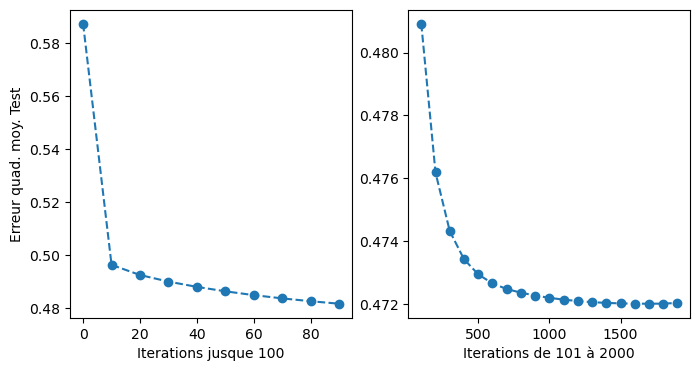

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
range_1 = range(0,100,10)
score_1 = np.abs(improvements[0:100:10])
plt.plot(range_1, score_1,'o--')
plt.xlabel('Iterations jusque 100')
plt.ylabel('Erreur quad. moy. Test')
plt.subplot(1,2,2)
range_2 = range(100,2000,100)
score_2 = np.abs(improvements[100:2000:100])
plt.plot(range_2, score_2,'o--')
plt.xlabel('Iterations de 101 à 2000')
plt.show()

# Machines à vecteurs de support (SVC)

## Classification SVC

In [15]:
from sklearn import datasets
digits = datasets.load_digits()
X, y = digits.data, digits.target

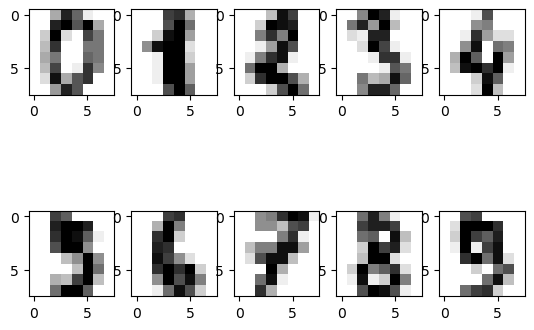

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

for k,img in enumerate(range(10)):
    plt.subplot(2, 5, k+1)
    plt.imshow(digits.images[img], 
               cmap='binary', 
               interpolation='none')
plt.show()

In [17]:
print(X[0])

[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


In [18]:
print(X[0].reshape(8,8))

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


In [19]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([178, 182, 177, 183, 181, 182, 181, 179, 174, 180], dtype=int64))

In [20]:
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
X_tr, X_t, y_tr, y_t = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [21]:
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(X_tr)
X_tr = scaling.transform(X_tr)
X_t = scaling.transform(X_t)

In [22]:
from sklearn.svm import SVC
svc = SVC(kernel='linear', 
          class_weight='balanced')

In [23]:
cv = cross_val_score(svc, X_tr, y_tr, cv=10)
test_score = svc.fit(X_tr, y_tr).score(X_t, y_t)

In [24]:
print(f'Score exactitude CV: {np.mean(cv):.3f}')
print(f'Score exactitude Test: {test_score:.3f}')

Score exactitude CV: 0.981
Score exactitude Test: 0.976


In [25]:
from sklearn.model_selection  import GridSearchCV
svc = SVC(class_weight='balanced', random_state=1)
search_space = {'C': np.logspace(-3, 3, 7)}
gridsearch = GridSearchCV(svc, 
                          param_grid=search_space, 
                          scoring='accuracy', 
                          refit=True, cv=10)
gridsearch.fit(X_tr,y_tr)

GridSearchCV(cv=10, estimator=SVC(class_weight='balanced', random_state=1),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring='accuracy')

In [26]:
cv = gridsearch.best_score_
test_score = gridsearch.score(X_t, y_t)
best_c =  gridsearch.best_params_['C']

In [27]:
print(f'Score exactitude CV: {cv:.3f}')
print(f'Score exactitude Test: {test_score:.3f}')
print(f'Meilleur paramètre C: {best_c:.1f}')

Score exactitude CV: 0.990
Score exactitude Test: 0.993
Meilleur paramètre C: 10.0


## Non linéarité

In [28]:
from sklearn.model_selection import GridSearchCV
svc = SVC(class_weight='balanced', random_state=1)
search_space = [{'kernel': ['linear'], 
                 'C': np.logspace(-3, 3, 7)},
                {'kernel': ['rbf'], 
                 'degree':[2, 3, 4], 
                 'C':np.logspace(-3, 3, 7), 
                 'gamma': np.logspace(-3, 2, 6)}]
gridsearch = GridSearchCV(svc, 
                          param_grid=search_space, 
                          scoring='accuracy', 
                          refit=True, cv=10,
                          n_jobs=-1)
gridsearch.fit(X_tr, y_tr)
cv = gridsearch.best_score_
test_score = gridsearch.score(X_t, y_t)
print(f'Score exactitude CV: {cv:0.3f}')
print(f'Score exactitude Test: {test_score:0.3f}')
print(f'Meilleurs paramètres: {gridsearch.best_params_}')

Score exactitude CV: 0.990
Score exactitude Test: 0.993
Meilleurs paramètres: {'C': 1.0, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}


## Régression avec SVR

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=500, 
                       n_features=15, 
                       n_informative=3, 
                       noise=10,
                       random_state=101)

X_tr, X_t, y_tr, y_t = train_test_split(X, y, 
                                        test_size=0.3, 
                                        random_state=0)
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(X_tr)
X_tr = scaling.transform(X_tr)
X_t  = scaling.transform(X_t)

In [30]:
svr = SVR()
search_space = [{'kernel': ['linear'], 
                 'C': np.logspace(-3, 2, 6), 
                 'epsilon': [0, 0.01, 0.1, 0.5, 1, 2, 4]},
                {'kernel': ['rbf'], 
                 'degree':[2,3], 
                 'C':np.logspace(-3, 3, 7), 
                 'gamma': np.logspace(-3, 2, 6), 
                 'epsilon': [0, 0.01, 0.1, 0.5, 1, 2, 4]}]
gridsearch = GridSearchCV(svr, 
                          param_grid=search_space, 
                          refit=True, 
                          scoring= 'r2',
                          cv=10, n_jobs=-1)
gridsearch.fit(X_tr, y_tr)
cv = gridsearch.best_score_
test_score = gridsearch.score(X_t, y_t)
print(f'Score R2 CV: {cv:.3f}')
print(f'Score R2 Test: {test_score:.3f}')
print(f'Meilleurs paramètres: {gridsearch.best_params_}')

Score R2 CV: 0.990
Score R2 Test: 0.992
Meilleurs paramètres: {'C': 100.0, 'epsilon': 0.5, 'kernel': 'linear'}


## Solution stochastique avec SVM

In [31]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X,y = make_classification(n_samples=500, 
                          n_features=15, 
                          n_informative=5, 
                          random_state=101)
X_tr, X_t, y_tr, y_t = train_test_split(X, y, 
                                        test_size=0.3, 
                                        random_state=1)

from sklearn.svm import SVC, LinearSVC
svc = SVC(kernel='linear', random_state=0)
linear = LinearSVC(loss='hinge', max_iter=100_000, random_state=0)

svc.fit(X_tr, y_tr)
linear.fit(X_tr, y_tr)
svc_score = svc.score(X_t, y_t)
libsvc_score = linear.score(X_t, y_t)
print(f'Exactitude Test SVC: {svc_score:.3f}')
print(f'Exactitude Test LinearSVC: {libsvc_score:.3f}')

Exactitude Test SVC: 0.787
Exactitude Test LinearSVC: 0.787


C:\X\DATALOGY\ANACONDA\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [32]:
import timeit
import numpy as np

X,y = make_classification(n_samples=10**3, 
                          n_features=15, 
                          n_informative=5, 
                          random_state=101)
t_svc = timeit.timeit(
    'svc.fit(X, y)',
    'from __main__ import svc, X, y',
    number=3)
t_libsvc = timeit.timeit(
    'linear.fit(X, y)',
    'from __main__ import linear, X, y',
    number=3)
print(f'Meilleurs secs moy. pour SVC: {np.mean(t_svc):0.1f}')
print(f'Meilleurs secs moy. pour LinearSVC: '
      f'{np.mean(t_libsvc):0.1f}')

Meilleurs secs moy. pour SVC: 0.2
Meilleurs secs moy. pour LinearSVC: 0.1


C:\X\DATALOGY\ANACONDA\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\X\DATALOGY\ANACONDA\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\X\DATALOGY\ANACONDA\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [33]:
X,y = make_classification(n_samples=3*10**3, 
                          n_features=15, 
                          n_informative=5, 
                          random_state=101)
t_svc = timeit.timeit('svc.fit(X, y)',
                      'from __main__ import svc, X, y', 
                      number=3)
t_linear = timeit.timeit('linear.fit(X, y)',
                         'from __main__ import linear, X, y', 
                         number=3)
print(f'Temps moy. pour SVC: {np.mean(t_svc):0.1f} secs')
print(f'Temps moy. pour LinearSVC: {np.mean(t_linear):0.1f} secs')

Avg time for SVC: 2.0 secs
Avg time for LinearSVC: 0.1 secs


C:\X\DATALOGY\ANACONDA\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\X\DATALOGY\ANACONDA\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\X\DATALOGY\ANACONDA\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [34]:
X,y = make_classification(n_samples=5*10**4, 
                          n_features=15, 
                          n_informative=5, 
                          random_state=101)
t_svc = timeit.timeit('svc.fit(X, y)',
                      'from __main__ import svc, X, y', 
                      number=3)
t_linear = timeit.timeit('linear.fit(X, y)',
                         'from __main__ import linear, X, y', 
                         number=3)
print(f'Temps moy. pour SVC: {np.mean(t_svc):.1f} secs')
print(f'Temps moy. pour LinearSVC: {np.mean(t_linear):.1f} secs')

C:\X\DATALOGY\ANACONDA\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\X\DATALOGY\ANACONDA\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\X\DATALOGY\ANACONDA\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Temps moy. pour SVC: 1246.2 secs
Temps moy. pour LinearSVC: 6.7 secs


In [35]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
import timeit

from sklearn.linear_model import SGDClassifier
X, y = make_classification(n_samples=10**5, 
                           n_features=15, 
                           n_informative=10, 
                           random_state=101)
X_tr, X_t, y_tr, y_t = train_test_split(X, y,
                                        test_size=0.3, 
                                        random_state=1)

In [36]:
linear = LinearSVC(penalty='l2', 
                   loss='hinge', 
                   dual=True,
                   random_state=101)
linear.fit(X_tr, y_tr)
score = linear.score(X_t, y_t)
t = timeit.timeit("linear.fit(X_tr, y_tr)", 
        "from __main__ import linear, X_tr, y_tr", 
        number=1)
print(f'Exactitude  test LinearSVC: {score:.3f}')
print(f'Temps moyen pour LinearSVC: {np.mean(t):.1f} secs')

Exactitude  test LinearSVC: 0.796
Temps moyen pour LinearSVC: 5.7 secs


In [37]:
sgd = SGDClassifier(loss='hinge',
                    penalty='l2',
                    alpha=0.1,
                    max_iter=1000, 
                    shuffle=True, 
                    random_state=101)
sgd.fit(X_tr, y_tr)
score = sgd.score(X_t, y_t)
t = timeit.timeit("sgd.fit(X_tr, y_tr)", 
                  "from __main__ import sgd, X_tr, y_tr", 
                  number=1)
print(f'Exactitude  test SGDClassifier: {score:.3f}')
print(f'Temps moyen pour SGDClassifier: {np.mean(t):.1f} secs')

Exactitude  test SGDClassifier: 0.796
Temps moyen pour SGDClassifier: 0.2 secs


# Réseaux neuronaux

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_digits
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits

X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

ModuleNotFoundError: No module named 'keras'

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
num_classes = 10
y_train = np.eye(num_classes)[y_train]
y_test = np.eye(num_classes)[y_test]

In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(64,)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Score exactitude Test:', accuracy)

In [ ]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Tracé des pertes selon les epochs
epochs = range(5, len(train_loss) + 1)
plt.plot(epochs, train_loss[4:], 'b', 
         label='Perte Training')
plt.plot(epochs, val_loss[4:], 'r', 
         label='Perte Validation')
plt.axvline(x=val_loss.index(min(val_loss)), 
            color='r', linestyle='--')
plt.title('Perte Training et Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()